
### Introduction

In [ ]:
# general imports
import pandas as pd
import numpy as np
import math

# imports for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# SKlearn distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity

# SKlearn scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

# Sklearn model creation
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# SKlearn vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# SKlearn accuracy evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# SKlearn evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# SKlearn combinations & gridsearch
from sklearn.model_selection import GridSearchCV
from itertools import combinations

#SKlearn one hot encoder
from sklearn.preprocessing import OneHotEncoder

# SKlearn regressors
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# SKlearn errors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# time series split, for time-based data
from sklearn.model_selection import TimeSeriesSplit

# SKlearn Clustering
from sklearn.cluster import KMeans
from contextlib import redirect_stderr

# Additional
import random
import warnings
from pandas.tseries.offsets import DateOffset
import statsmodels.api as sm

In [ ]:
def access_excel_from_github(url, sheet_name):
    # Read the Excel file from the URL directly
    df = pd.read_excel(url, sheet_name=sheet_name, engine='openpyxl')
    return df

# Question 1

**Analytical Question**:

Among the 100 top companies, can we observe groups of companies that share similar features?



**Comments**: We have many features of the top 100 companies here. We aim to identify if these companies can be segmented into different groups. The reason why this is a relevant question is because we can observe patterns in the groupings which allow us to identify certain themes of "successful" companies. There might be certain groupings of successful companies which have certain characteristics/secrets to success.



**Data Used**: For this question, we will be looking at the data of the top 100 companies, focusing on the current statistics. Currently, the data for each of the companies are separately located. The data used for this question will be pre-processed and obtained by merging the most recent financial statistics of the top 100 companies. The end data frame we are looking at has 100 observations, with each one representing a company. The features we are looking at are the different financial statistics, consisting of 220 base features. We might use more features as interaction terms, and/or include transformations of the base features.



**Proposed Solution**: We will be using unsupervised learning algorithms to find clusters within the top 100 companies by market cap in the S&P 500
K-means is the algorithms we will use
We will tune the hyperparameters based on elbow and silhouette method to obtain the optimal K value.
We will engage in data-preprocessing to handle outliers
We will then proceed to find the centroids and their corresponding values for features. We will also analyze the number of companies in each cluster and see if we can obtain any insight on the characteristics common to each cluster.



**Proposed Evaluation**:
We evaluate the clusters by calculating the between cluster distance and the within cluster distance. We aim to maximize cluster distance and minimize within cluster distance. Our 2 main metrics for this is the Sihouette Score and the Within Cluster Sum of Squares.

We will evaluate the clustering method with respect to the documentation from SKlearn: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


### Explanation of key terms in the data

### Pre-processing of data

**Missing Values**

Rationale for inputting missing data with backwards data: There are many misising values in the data which cannot be ignored. By backwards filling, we are assuming that the data from the past holds and remains constant.

In [ ]:
df = access_excel_from_github('https://github.com/Nayrbnat/DS-112/raw/main/Qn1/Qualities%20of%20Good%20Companies.xlsx', 'Data')
df.columns = df.iloc[3,]
df = df.iloc[6:,:].reset_index(drop=True)

# Adjusting for duplicates
duplicates = df.columns.duplicated()

if duplicates.any():
    new_columns = pd.Series(df.columns).astype(str) + pd.Series(range(len(df.columns))).astype(str)
    df.columns = pd.Series(df.columns).where(~duplicates, new_columns)
# Filling NA values with future values
df = df.bfill().ffill() #Fill missing values with forward values, in the event there exist no forward value, fill with backvalue

# Check for NA values
df.isna().sum()

,0
3,
SP_ENTITY_NAME,0
SP_ENTITY_ID,0
SP_GEOGRAPHY,0
SP_COMPANY_TYPE,0
SP_MARKETCAP_PERIOD_END,0
SP_TOTAL_REV,0
SP_EBITDA,0
SP_EBIT,0
SP_NET_INC,0


In [ ]:
# Renaming the columns
df = df.rename(columns = {
    'SP_ENTITY_NAME': 'Company',
    'SP_ENTITY_ID': 'S&P ID',
    'SP_GEOGRAPHY': 'Geography',
    'SP_COMPANY_TYPE': 'Company Type',
    'SP_MARKETCAP_PERIOD_END': 'Market Cap',
    'SP_TOTAL_REV': 'Total Revenue',
    'SP_EBITDA': 'EBITDA_LFY',
    'SP_EBIT': 'EBIT_LFY',
    'SP_NET_INC': 'Net Income_LFY',
    'SP_TEV_EBITDA': 'TEV/EBITDA',
    'SP_PE': 'SP_P/E after extra',
    'SP_PBV_X': 'SP_P/B',
    'SP_DEBT_TO_EQUITY': 'Total Debt/Total Equity',
    'SP_ROA': 'ROAA',
    'SP_ROE': 'ROAE',
    'SP_BVPS': 'Basic Book Value per shares',
    'SP_DIV_YIELD': 'Dividend Yield',
    'SP_VOLUME_AVG_DAILY': 'Volume',
    'SP_SHORT_INT': 'Short Interest Jun 24',
    'SP_SHORT_INT_RATIO': 'Short Interest Ratio_1D',
    'SP_BETA1YR': 'Beta_1Y',
    'SP_BETA_3YR': 'Beta_3Y',
    'SP_EPS_MEDIAN_EST': 'FY26_Median_EPS_EST',
    'SP_EPS_REPORTED_EST': 'FY26_Median_EPS_EST_GAAP',
    'SP_CASH_EPS_MEDIAN_EST': 'FY26_Median_Cash_EPS_EST',
    'SP_DPS_MEDIAN_EST': 'FY26_Median_DPS_EST',
    'SP_FCF_MEDIAN_EST': 'FY26_Median_FCF_EST',
    'IQ_TEV_EBIT_OUT': 'Diluted_TEV/EBIT',
    'IQ_TEV_EBITDA_OUT': 'Diluted_TEV/EBITDA',
    'IQ_PBV_X': 'IQ_P/B',
    'IQ_PE': 'IQ_P/E',
    'SP_TEV_EBIT_FWD_OUT': 'FY26_Forward_TEV/EBIT',
    '354780': 'Total Earnings Transcript Net Positivity Score',
    'SP_PCT_HELD_BY_INST_OWNER': 'Percent Institution Ownership (Owner 1)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER': 'Percentage change in insider holder (Owner 1)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER35': 'Percentage change in insider holder (Owner 2)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER36': 'Percentage change in insider holder (Owner 3)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER37': 'Percentage change in insider holder (Owner 4)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER38': 'Percentage change in insider holder (Owner 5)',
    'SP_PCT_HELD_BY_INSIDER_OWNER': 'Percent Insider Ownership (Owner 1)',
    'SP_PCT_HELD_BY_INSIDER_OWNER40': 'Percent Insider Ownership (Owner 2)',
    'SP_PCT_HELD_BY_INSIDER_OWNER41': 'Percent Insider Ownership (Owner 3)',
    'SP_PCT_HELD_BY_INSIDER_OWNER42': 'Percent Insider Ownership (Owner 4)',
    'SP_PCT_HELD_BY_INSIDER_OWNER43': 'Percent Insider Ownership (Owner 5)',
    'IQ_INDUSTRY': 'Industry',
    'IQ_SECTOR': 'Sector',
    'RD_CREDIT_RATING_GLOBAL': 'S&P Credit Rating',
    'PCT_OWNED_INSIDERS': 'Total Percent Insider Ownership',
    'SP_NO_INSTITUTIONAL_INVESTORS': 'Number of Institutional Investors'})
df_numeric = df.drop(columns = ['Company','Company Type','Sector','Industry','S&P Credit Rating','Geography','FY26_Median_EPS_EST_GAAP','IQ_P/B','IQ_P/E','Diluted_TEV/EBITDA']).apply(pd.to_numeric, errors='coerce').dropna()
df_numeric.columns

Index(['S&P ID', 'Market Cap', 'Total Revenue', 'EBITDA_LFY', 'EBIT_LFY',
       'Net Income_LFY', 'TEV/EBITDA', 'SP_P/E after extra', 'SP_P/B',
       'Total Debt/Total Equity', 'ROAA', 'ROAE',
       'Basic Book Value per shares', 'Dividend Yield', 'Volume',
       'Short Interest Jun 24', 'Short Interest Ratio_1D', 'Beta_1Y',
       'Beta_3Y', 'FY26_Median_EPS_EST', 'FY26_Median_Cash_EPS_EST',
       'FY26_Median_DPS_EST', 'FY26_Median_FCF_EST', 'Diluted_TEV/EBIT',
       'FY26_Forward_TEV/EBIT',
       'Total Earnings Transcript Net Positivity Score',
       'Percent Institution Ownership (Owner 1)',
       'Percentage change in insider holder (Owner 1)',
       'Percentage change in insider holder (Owner 2)',
       'Percentage change in insider holder (Owner 3)',
       'Percentage change in insider holder (Owner 4)',
       'Percentage change in insider holder (Owner 5)',
       'Percent Insider Ownership (Owner 1)',
       'Percent Insider Ownership (Owner 2)',
       'Percent 

In [ ]:
# Removing outliers
outlier_count = pd.Series(0, index=df_numeric.index)  # Initialize a series to count outliers for each row

for col in df_numeric.columns:
    Q1 = df_numeric[col].quantile(0.25)  # 25th percentile
    Q3 = df_numeric[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                        # Interquartile Range

    # Calculate lower and upper bounds for outliers
    lower_bound = Q1 - 10 * IQR
    upper_bound = Q3 + 10 * IQR

    # Identify outliers
    col_outliers = df_numeric[(df_numeric[col] < lower_bound) | (df_numeric[col] > upper_bound)]

    # Increment the count of outliers for these rows
    outlier_count[col_outliers.index] += 1

# Flag rows as outliers if they have outliers in more than 5 columns
outliers = outlier_count[outlier_count > 5].index.tolist()

# Finding the companies that appear as outliers
df_outliers = df.iloc[outliers]

df_outliers

3,Company,S&P ID,Geography,Company Type,Market Cap,Total Revenue,EBITDA_LFY,EBIT_LFY,Net Income_LFY,TEV/EBITDA,...,Percent Insider Ownership (Owner 1),Percent Insider Ownership (Owner 2),Percent Insider Ownership (Owner 3),Percent Insider Ownership (Owner 4),Percent Insider Ownership (Owner 5),Industry,Sector,S&P Credit Rating,Total Percent Insider Ownership,Number of Institutional Investors
2,Alphabet Inc. (NASDAQGS:GOOGL),4633618,United States and Canada,Public Company,1.740537e+06,307394000.0,100172000.0,88226000.0,73795000.0,17.050398,...,5.91,3.16,0.90,0.32,0.04,Interactive Media and Services,Communication Services,AA+,10.38,5330
8,"Apollo Global Management, Inc. (NYSE:APO)",4204256,United States and Canada,Public Company,5.290983e+04,31944000.0,6006000.0,2919500.0,6509000.0,13.721773,...,7.31,6.03,4.89,1.01,0.63,Financial Services,Financials,A,21.10,1067
22,Brookfield Corporation (TSX:BN),4066647,United States and Canada,Public Company,6.131298e+04,97992000.0,25589000.0,16514000.0,5105000.0,16.326749,...,3.59,2.63,1.42,1.10,0.82,Capital Markets,Financials,A-,10.99,890
49,KKR & Co. Inc. (NYSE:KKR),4165107,United States and Canada,Public Company,7.332271e+04,18663644.0,3784000.0,142933000.0,5357086.0,39.691641,...,9.94,9.34,2.37,2.07,0.35,Capital Markets,Financials,A,24.27,1180


There are clearly outliers in this case, let me implement a function that removes outliers

In [ ]:
# Remove outliers
df_full = df.copy()
df = df.drop(outliers)
df.shape[0]

96

# Part 1 - Exploratory Data Analysis (EDA)


---



## Understanding the Features/Predictors

In [ ]:
# Identifying the number of unique values for each feature to classify as numeric or categorical
def unique_values_df(df):
    unique_counts = df.nunique()
    return pd.DataFrame(unique_counts, columns=['Unique_Values'])

In [ ]:
# How many unique values does each predictor have?
unique_values_df(df).sort_values(by='Unique_Values', ascending=True).head(10)

,Unique_Values
3,
Geography,1
Company Type,1
Percent Insider Ownership (Owner 5),8
Sector,10
Percent Insider Ownership (Owner 4),11
S&P Credit Rating,12
Percent Insider Ownership (Owner 3),13
Industry,24
Percent Insider Ownership (Owner 2),26


In [ ]:
df.columns

Index(['Company', 'S&P ID', 'Geography', 'Company Type', 'Market Cap',
       'Total Revenue', 'EBITDA_LFY', 'EBIT_LFY', 'Net Income_LFY',
       'TEV/EBITDA', 'SP_P/E after extra', 'SP_P/B', 'Total Debt/Total Equity',
       'ROAA', 'ROAE', 'Basic Book Value per shares', 'Dividend Yield',
       'Volume', 'Short Interest Jun 24', 'Short Interest Ratio_1D', 'Beta_1Y',
       'Beta_3Y', 'FY26_Median_EPS_EST', 'FY26_Median_EPS_EST_GAAP',
       'FY26_Median_Cash_EPS_EST', 'FY26_Median_DPS_EST',
       'FY26_Median_FCF_EST', 'Diluted_TEV/EBIT', 'Diluted_TEV/EBITDA',
       'IQ_P/B', 'IQ_P/E', 'FY26_Forward_TEV/EBIT',
       'Total Earnings Transcript Net Positivity Score',
       'Percent Institution Ownership (Owner 1)',
       'Percentage change in insider holder (Owner 1)',
       'Percentage change in insider holder (Owner 2)',
       'Percentage change in insider holder (Owner 3)',
       'Percentage change in insider holder (Owner 4)',
       'Percentage change in insider holder (Ow

**List of numerical variables**: All other variables

**List of categorical variables**: Geography, Company Type, S&P Credit Rating, Sector, Industry

## Checking for Multi-Collinearity between features

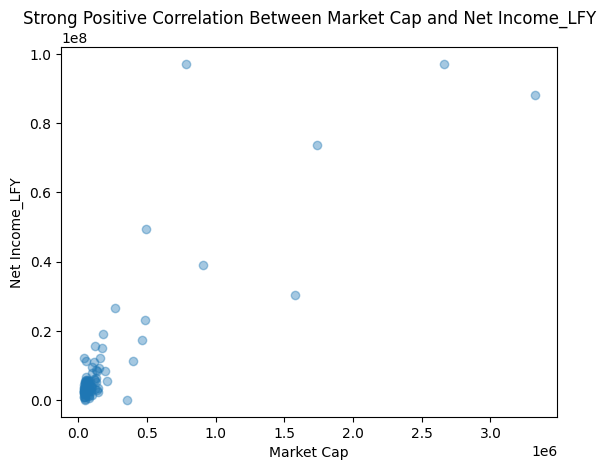

The correlation value between the two features are 0.9252489395177612.


In [ ]:
# check for multi-collinearity, some numeric columns have strings as data
df_corr = df_numeric.drop(columns= ['Percent Insider Ownership (Owner 1)','Percent Insider Ownership (Owner 2)','Percent Insider Ownership (Owner 3)','Percent Insider Ownership (Owner 4)','Percent Insider Ownership (Owner 5)']).drop(17).corr()
# create and apply a mask to eliminate the correlation of one variable with itself
mask = np.triu(np.ones_like(df_corr, dtype=bool), k=1)
masked_corr = df_corr.where(mask)

# Find and plot the visualisation of the index of the most positive correlation value
max_corr_value = masked_corr.max().max()
max_corr_idx = masked_corr.stack()[masked_corr.stack() == max_corr_value].index

# identify the features
feature1 = max_corr_idx[0][0]
feature2 = max_corr_idx[0][1]

fig = plt.scatter(x=df_numeric[feature1], y=df_numeric[feature2], alpha=0.4)

# label the diagram
plt.title(f'Strong Positive Correlation Between {feature1} and {feature2}')
plt.xlabel(feature1)
plt.ylabel(feature2)

plt.show()
print(f"The correlation value between the two features are {max_corr_value}.")

This is not surprising given that Net Income is the bottom line of every company. It is used to calculat the P/E ratio, one of the most common valuation metrics amongst investors.

# Part 2 Unsupervised Learning (K-means Clustering)


---



Here we adopt K-means clustering as a means to identify any initial similarities between points. K-means is an important clustering technique as it works for datasets with many features. We will be using euclidean distance

To choose the correct number of clusters (K), I will aim to minimise within cluster distance and maximise between cluster distance. I will employ the elbow plot for this

## Finding the Optimal No. of Clusters

Although I arbitrarily decided on 3 clusters for K-means, there is a more rigorous approach to identify the optimal number of clsuters. Let me evaluate the K-Means clustering technique with the following methods:

1. **Intercluster distances and Within Cluster distance**



$$\text{WCSS} = \sum_{k=1}^{K} \sum_{i \in C_k} \| \mathbf{x}_i - \mathbf{c}_k \|^2$$

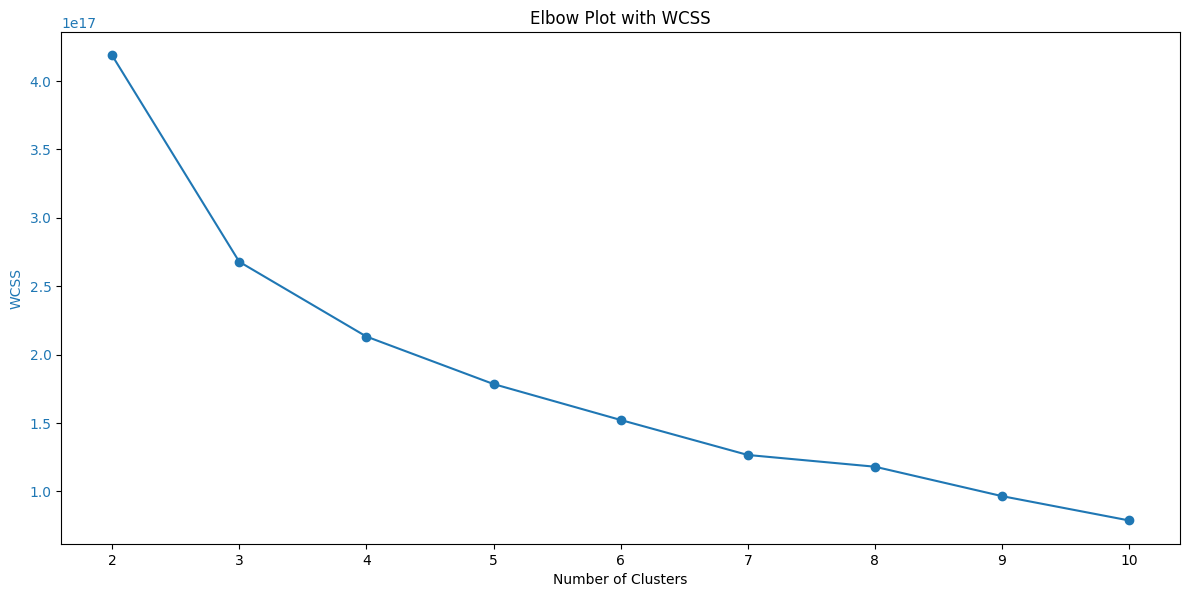

In [ ]:
# Calculating the within cluster sum of squares
X_train = df_numeric
# Define the range of clusters to test
cluster_range = range(2, 11)
# Lists to store WCSS and Between-Cluster distances
wcss = []
between_cluster_distances = []

# Compute WCSS and Between-Cluster distances for different numbers of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Compute WCSS (Within-Cluster Sum of Squares)
    wcss.append(kmeans.inertia_)

    if n_clusters > 1:
        # Compute Between-Cluster Distance
        # Compute the centroid distances
        centroids = kmeans.cluster_centers_
        distances = np.zeros((n_clusters, n_clusters))
        for i in range(n_clusters):
            for j in range(i + 1, n_clusters):
                distances[i, j] = np.linalg.norm(centroids[i] - centroids[j])
        # Sum of all pairwise distances
        between_cluster_distances.append(distances.sum())

# Plot the Elbow Curve
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(cluster_range, wcss, marker='o', color=color, label='WCSS')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(min(cluster_range), max(cluster_range) + 1))

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.title('Elbow Plot with WCSS')
plt.show()

$$
\text{Inertia Metric}=\frac{1}{n} \sum_{i=1}^{n} (\text{distance}(\text{point}_i, \text{centroid})^2)$$

We then plot the Elbow plot for within cluster sum of squares against values of K. In this case we are using the inerta metric: which is the sum of the squared distances of samples to their closest cluster center.

A good clustering algorithm minimises the distances between centroid and observations around the centroid. We want fewer clusters because having greater number of clusters might give us a lower WCSS but suggests that we are overfitting the data. Hence we want to optimize for this by finding the kink in the elbow plot.

2. **Sihouette Coefficient**

The Silhouette Score for a single data ppint S(i) ranges from -1 to +1. A higher silhouette score indicates that the sample is well-clustered and has low within cluster distance while having high between cluster distance.

$$ S(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$

 $$ \text{Overall Silhouette score (S)} =\frac{1}{N} \sum_{i=1}^{N} S(i)$$

Silhouette Score with 2 clusters: 0.79
Silhouette Score with 3 clusters: 0.57
Silhouette Score with 4 clusters: 0.56
Silhouette Score with 5 clusters: 0.53
Silhouette Score with 6 clusters: 0.56
Silhouette Score with 7 clusters: 0.46
Silhouette Score with 8 clusters: 0.49
Silhouette Score with 9 clusters: 0.49
Silhouette Score with 10 clusters: 0.50


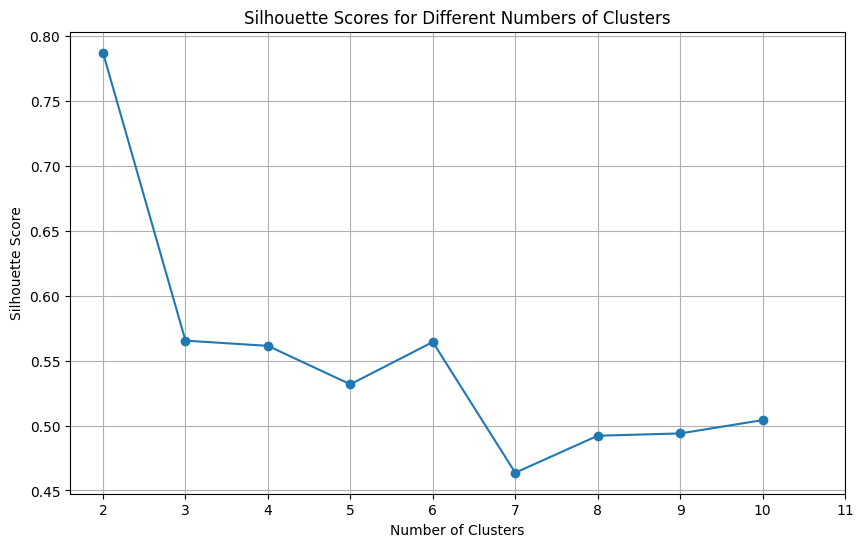

In [ ]:
warnings.filterwarnings('ignore')
# Computing the Silhouette Coefficient across different clusters
silhouette_scores = []

# Loop through the range of clusters from 2 to 11
for n_clusters in cluster_range:
    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette Score with {n_clusters} clusters: {silhouette_avg:.2f}")

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color='tab:blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xticks(range(2, 12))
plt.grid(True)
plt.show()

In [ ]:
print('The WCSS for cluster of 3 is:',wcss[cluster_range.index(3)])

The WCSS for cluster of 3 is: 2.6787500755016278e+17


This tells me that the optimal number of clusters for the K-means algorithm for this dataset is 3.

Although a cluster of 2 has a higher silhouette score, it also has a higher within cluster sum of squares. Hence, the optimal number of clusters where there is an elbow kink is 3 or 6. In this case we will use 3 clusters as it is easier to visualize and draw insights from.

**Insights from K-means Clustering**

- K-means is a useful clustering tool to cluster observations into groups and is computationally inexpensive.
- We are able to derive insights from the coordinates of the centroids and the number of observations in each cluster


**Limitations of K-means Clustering**

- We need to specify the number of clusters to be used for K-means clustering. FUrthermore it might not capture anomalies as well as other clustering methods.

# Analyzing the pairwise plots

In [ ]:
X_train.columns

Index(['S&P ID', 'Market Cap', 'Total Revenue', 'EBITDA_LFY', 'EBIT_LFY',
       'Net Income_LFY', 'TEV/EBITDA', 'SP_P/E after extra', 'SP_P/B',
       'Total Debt/Total Equity', 'ROAA', 'ROAE',
       'Basic Book Value per shares', 'Dividend Yield', 'Volume',
       'Short Interest Jun 24', 'Short Interest Ratio_1D', 'Beta_1Y',
       'Beta_3Y', 'FY26_Median_EPS_EST', 'FY26_Median_Cash_EPS_EST',
       'FY26_Median_DPS_EST', 'FY26_Median_FCF_EST', 'Diluted_TEV/EBIT',
       'FY26_Forward_TEV/EBIT',
       'Total Earnings Transcript Net Positivity Score',
       'Percent Institution Ownership (Owner 1)',
       'Percentage change in insider holder (Owner 1)',
       'Percentage change in insider holder (Owner 2)',
       'Percentage change in insider holder (Owner 3)',
       'Percentage change in insider holder (Owner 4)',
       'Percentage change in insider holder (Owner 5)',
       'Percent Insider Ownership (Owner 1)',
       'Percent Insider Ownership (Owner 2)',
       'Percent 

In [ ]:
len(X_train.columns)

39

Given that I have 39 predictors, there was 39C2 = 741 possible combinations of features. However, it is impossible/not relevant to plot 703 plots to derive insights from. Hence I will randomly sample 12 different plots and showcase different plots that are interesting to derive insights from.

In [ ]:
#Standardizing the X variables
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
# Creating the K-means model
model = KMeans(n_clusters=3, init= 'random', n_init=1, random_state = 100)
model.fit(X_train)

KMeans(init='random', n_clusters=3, n_init=1, random_state=100)

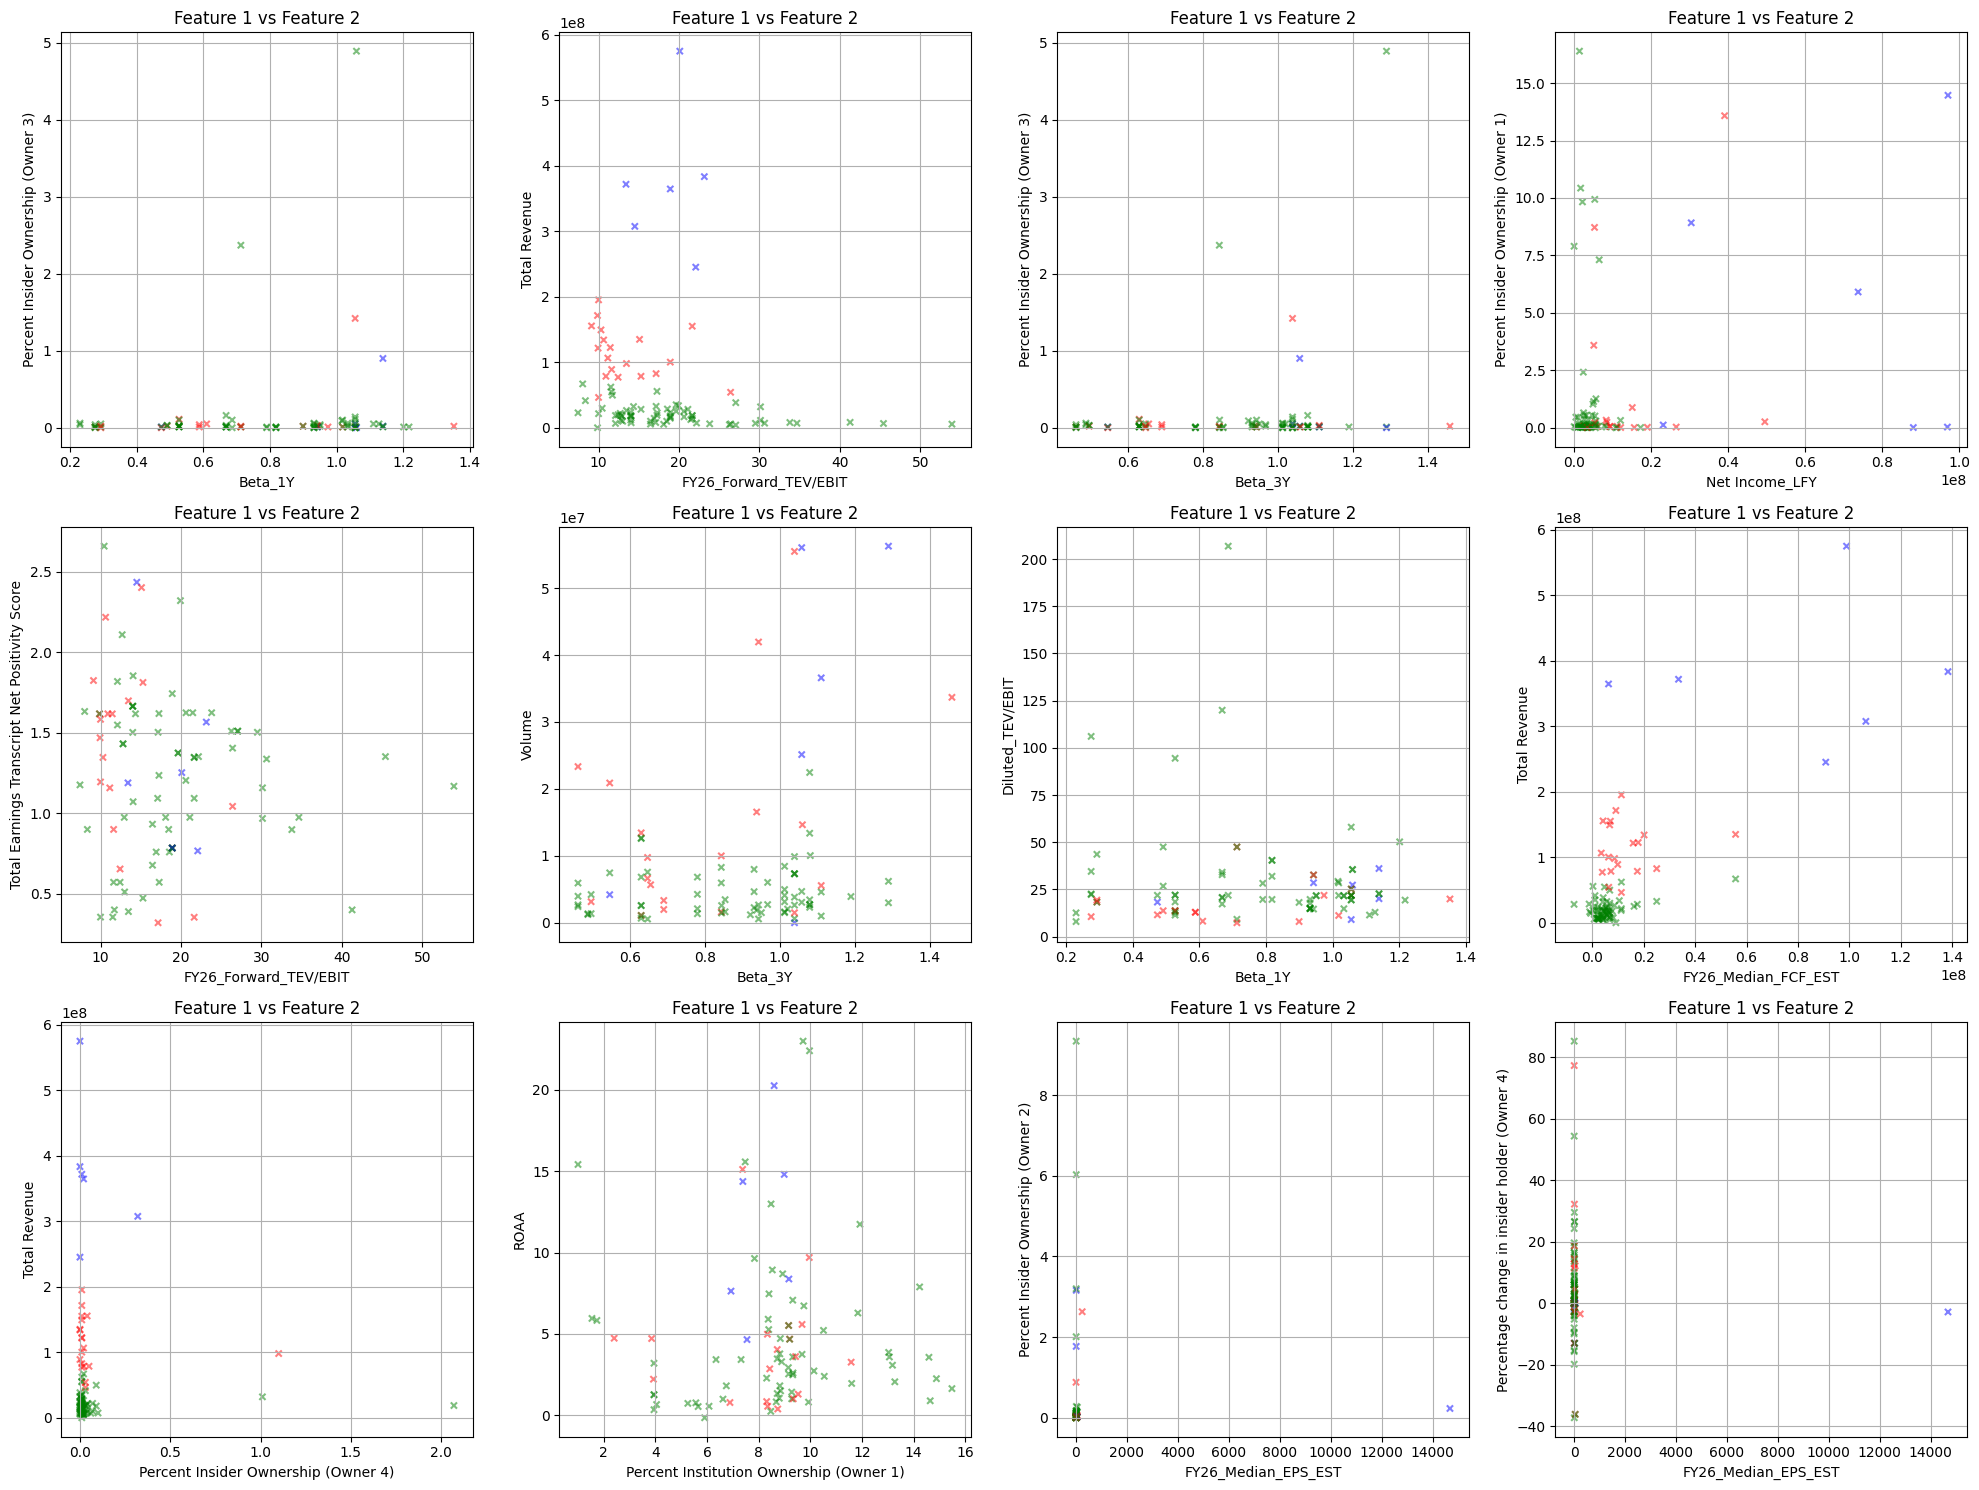

In [ ]:
# Because of the high dimensionality of the data, it doesn't make sense to make a pairwise plot of all the features with clusters. I will randomly sample 10 columns
pairs = list(combinations(X_train.columns.difference(['Cluster']), 2))
# Plotting the clustering for pairwise variables
pairs_to_plot = random.sample(pairs, 12)

X_train['Cluster'] = model.labels_

cmap = {0: 'red', 1: 'blue', 2: 'green'}
# Create the pairplot
fig, axes = plt.subplots(3, 4, figsize=(20, 15))  # Adjust grid size if needed
axes = axes.flatten()

for ax, (col1, col2) in zip(axes, pairs_to_plot):
    X_train.plot.scatter(x=col1, y=col2, c=X_train['Cluster'].map(cmap), marker="x", alpha=0.5, ax=ax)
    ax.set_title('Feature 1 vs Feature 2')
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.grid(True)

# Hide any unused subplots
for i in range(len(pairs_to_plot), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Question 1A - What Features are Important?

**Choosing specific features to plot**

Given the high-dimensionality of the data, it is difficult to showcase the clustering with all the features. Hence, our solution is to visualize this with 2 features and conduct random sampling across the features.

Based on random sampling of 12 combinations of 2 features, I decided on plotting the following plots to draw inference from:

1. Volume X Total Revenue
2. Total percent insider ownership X Total revenue
3. Market Cap X Volume


In [ ]:
X_train.columns

Index(['S&P ID', 'Market Cap', 'Total Revenue', 'EBITDA_LFY', 'EBIT_LFY',
       'Net Income_LFY', 'TEV/EBITDA', 'SP_P/E after extra', 'SP_P/B',
       'Total Debt/Total Equity', 'ROAA', 'ROAE',
       'Basic Book Value per shares', 'Dividend Yield', 'Volume',
       'Short Interest Jun 24', 'Short Interest Ratio_1D', 'Beta_1Y',
       'Beta_3Y', 'FY26_Median_EPS_EST', 'FY26_Median_Cash_EPS_EST',
       'FY26_Median_DPS_EST', 'FY26_Median_FCF_EST', 'Diluted_TEV/EBIT',
       'FY26_Forward_TEV/EBIT',
       'Total Earnings Transcript Net Positivity Score',
       'Percent Institution Ownership (Owner 1)',
       'Percentage change in insider holder (Owner 1)',
       'Percentage change in insider holder (Owner 2)',
       'Percentage change in insider holder (Owner 3)',
       'Percentage change in insider holder (Owner 4)',
       'Percentage change in insider holder (Owner 5)',
       'Percent Insider Ownership (Owner 1)',
       'Percent Insider Ownership (Owner 2)',
       'Percent 

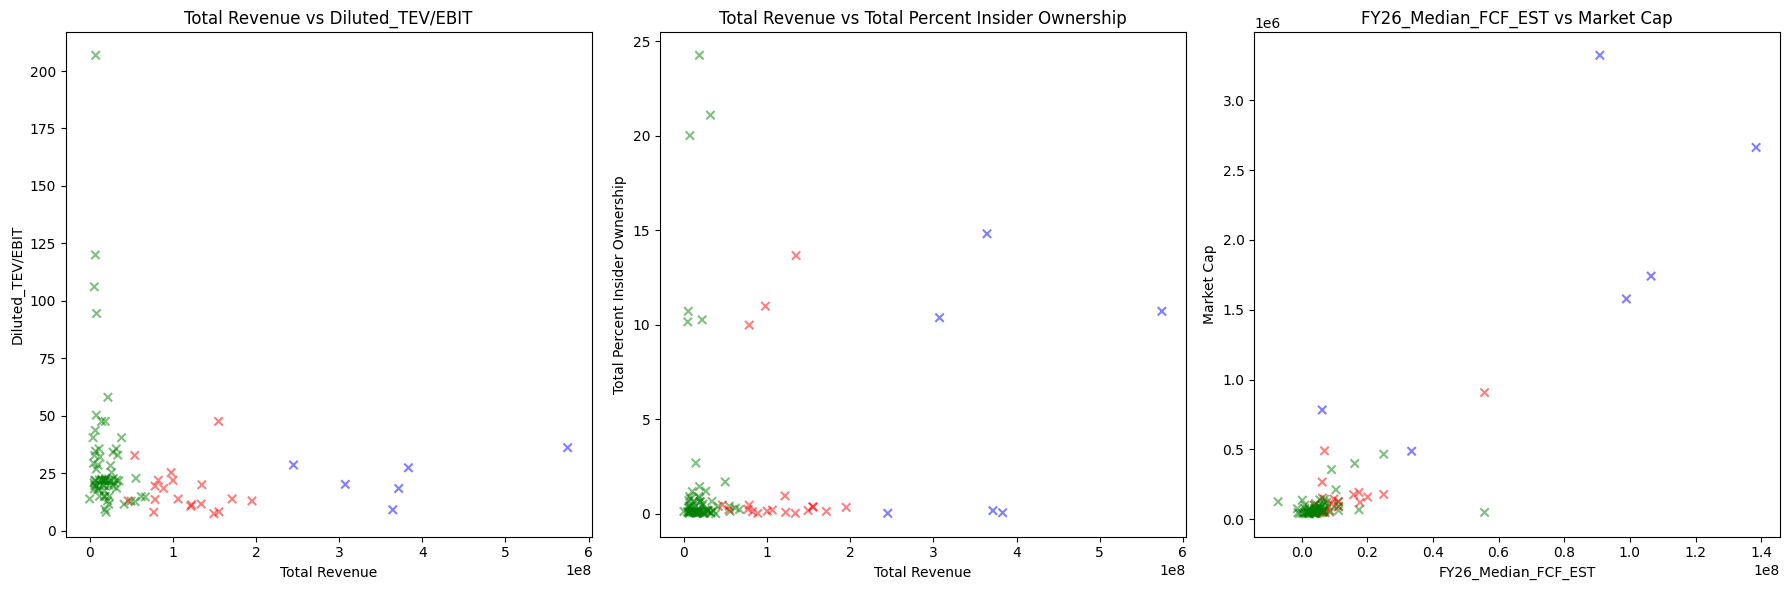

In [ ]:
# Define the X variables to plot and the Y variable
x_vars = ['Total Revenue', 'Total Revenue', 'FY26_Median_FCF_EST']
y_vars = ['Diluted_TEV/EBIT', 'Total Percent Insider Ownership', 'Market Cap']

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot each scatter plot on a separate axis
for ax, x_var, y_var in zip(axes, x_vars, y_vars):
    # Ensure x and y have the same length
    x_data = X_train[x_var]
    y_data = X_train[y_var]
    scatter = ax.scatter(x_data, y_data,
                         c=X_train['Cluster'].map(cmap), marker='x', alpha=.5)
    ax.set_title(f'{x_var} vs {y_var}')
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The 3 graphs above show us that when looking at companies based on these 2 features, it is possible for us to group them quite nicely into 3 classes. This tells us that the top 100 companies by market cap in the US and Canada usually have certain similar types of characteristics.

1. From the first graph, we can see that all the companies in the top 100 list have a diluted EV/EBIT of less than 60. This reveals in general the maximum premium that investors are willing to pay for these companies. The clusters are clearly segmented by Revenue and not by EV/EBIT. Hence clusters are formed based on their topline sales rather than the premium investors are willing to pay for these companies

- We can also conclude that there are 3 different types of companies. Those that produce higher revenues tend to be classified in clusters of themselves, whereas the bulk of companies that make up the top 100 list have revenues around ~10 million.

2. From the second graph we can observe that the same clustering pattern exists and that even though there are 3 horizontal bands depending on the level of insider ownership, the revenue that a company generates is a more important feature that contributes to the clustering of the 3 groups. Hence the groups are split vertically rather than horizontally.

3. From the third graph we can see that expectations of how much Free Cash Flow a company generates is an important factor in a company's existence in the top 100 company list. This can be seen by the large concentration of datapoints near the origin point.


We observed also that if you plot any variable with respect to **total revenue**, the clusters are delineated based on **total revenue**. This tells us that **total revenue** is an important feature when it comes to importance of classifying clusters.

Another factor is **median estimated EPS and FCF**. This refers to the profit and cash that the company is estimated to generate in 2026. We can see that a key aspect of a company being highly valued by the market is the expectation of its earning potential in the future. This is because on the 3rd graph, the observations are all clustered together in 1 area.

## Evaluating cluster centroids

In [ ]:
# Define the features for clustering
random.seed(123)
features = ['Diluted_TEV/EBIT', 'Total Revenue', 'ROAA','Beta_3Y','Total Percent Insider Ownership','FY26_Median_FCF_EST','FY26_Median_EPS_EST']

# Fit KMeans model
model = KMeans(n_clusters=3, random_state=0)
model.fit(X_train[features])

# Get centroids
centroids = model.cluster_centers_

# Create a DataFrame for centroids
centroid_df = pd.DataFrame(centroids, columns=features)

# Display the centroid values for each cluster
print(centroid_df)

   Diluted_TEV/EBIT  Total Revenue       ROAA   Beta_3Y  \
0         30.502883   2.032346e+07   4.408915  0.871631   
1         23.234820   3.744483e+08  11.679539  1.016903   
2         16.643892   1.175744e+08   4.153083  0.815159   

   Total Percent Insider Ownership  FY26_Median_FCF_EST  FY26_Median_EPS_EST  
0                         1.785672         5.048054e+06            10.924392  
1                         6.030000         7.907797e+07          2459.244352  
2                         2.139444         1.584583e+07            26.921023  


## Results:

Companies in the top 100 by market capitalisation tend to have a certain expectation of **future free cash flow** generation and **earnings per share**. You can see that the centroid clusters have around the same magnitude for median free cash flow estimates

The 3 centroids determined by the K-means clustering method reveal that cluster 1 is very different from the othe 2 clusters, not in terms of just how many observations in each cluster but also the value of different features.
For example, just in terms of **Total Revenue**, **ROAA** and **percentage of insider ownership**, centroid 1 is a lot higher than the other 2.



In [ ]:
# Number of companies in each cluster
pd.Series(model.labels_).value_counts().sort_index()

,count
0,67
1,6
2,18


This tells me that one of the clusters comprises of a small group of companies. This group comprises 4 companies that belong to FAANG - Alphabet, Amazon and Apple and Google. These are very big tech companies that have extremely strong business fundamentals. Another great company in this list is Berkshire Hathaway run by Warren Buffett, known for his astute investment insights. Lastly, UnitedHealth Group is an insurance company and could be potentially a great business to invest in based on these findings if its quality is close to that of the other 4 businesses.

In [ ]:
X_train['Cluster'] = model.labels_
id_cluster_1 = X_train[X_train['Cluster'] == 1]['S&P ID']
df_full[df_full['S&P ID'].isin(id_cluster_1)]

3,Company,S&P ID,Geography,Company Type,Market Cap,Total Revenue,EBITDA_LFY,EBIT_LFY,Net Income_LFY,TEV/EBITDA,...,Percent Insider Ownership (Owner 1),Percent Insider Ownership (Owner 2),Percent Insider Ownership (Owner 3),Percent Insider Ownership (Owner 4),Percent Insider Ownership (Owner 5),Industry,Sector,S&P Credit Rating,Total Percent Insider Ownership,Number of Institutional Investors
2,Alphabet Inc. (NASDAQGS:GOOGL),4633618,United States and Canada,Public Company,1.740537e+06,307394000.0,100172000.0,88226000.0,73795000.0,17.050398,...,5.91,3.16,0.90,0.32,0.04,Interactive Media and Services,Communication Services,AA+,10.38,5330
3,"Amazon.com, Inc. (NASDAQGS:AMZN)",3001792,United States and Canada,Public Company,1.577593e+06,574785000.0,85515000.0,36852000.0,30425000.0,16.679114,...,8.92,1.77,0.02,0.00,0.00,Broadline Retail,Consumer Discretionary,AA,10.72,5753
9,Apple Inc. (NASDAQGS:AAPL),4004205,United States and Canada,Public Company,2.662326e+06,383285000.0,125820000.0,114301000.0,96995000.0,22.322527,...,0.03,0.02,0.00,0.00,0.00,"Technology Hardware, Storage and Peripherals",Information Technology,AA+,0.06,5873
17,Berkshire Hathaway Inc. (NYSE:BRK.A),103462,United States and Canada,Public Company,7.821848e+05,364482000.0,135682000.0,123196000.0,97147000.0,7.870353,...,14.47,0.23,0.05,0.02,0.02,Financial Services,Financials,AA,14.82,1125
57,Microsoft Corporation (NASDAQGS:MSFT),4004214,United States and Canada,Public Company,3.322626e+06,245122000.0,131720000.0,109433000.0,88136000.0,23.481184,...,0.01,0.01,0.01,0.00,0.00,Software,Information Technology,AAA,0.03,6404
93,UnitedHealth Group Incorporated (NYSE:UNH),111568,United States and Canada,Public Company,4.864583e+05,371622000.0,36330000.0,32358000.0,23144000.0,21.240326,...,0.12,0.02,0.01,0.01,0.00,Health Care Providers and Services,Health Care,A+,0.17,4014


# Conclusion

---








We can see that when clustering the top 100 companies, there are some sub clusters that emerge. Specifically there is a small cluster of companies which come from various different sectors. These companies share a similarity in that they have high revenue, they employ capital efficiently (High ROAA) and have high insider ownership.
In the graphs above we can see that this cluster is an "outlier" in the sense whereby they have very high market capitalisation and expectations of free cash flow.
From domain knowledge, I know that 3 of these 5 companies belong to FAANG, companies that are heavily involved in technology (big tech). The other 2 companies are also great businesses and we can conclude that this cluster is an exceptional group of successful companies.

This is an exceptional subgroup of companies that have been identified through K-means clustering. This is very exciting given that we did not provide K-means with categorical data such as industry or sector and it merely clusterd these companies together based on quantitative features.

In [ ]:
# @markdown Run this cell to download this notebook as a webpage, `_NOTEBOOK.html`.

import google, json, nbformat

# Get the current notebook and write it to _NOTEBOOK.ipynb
raw_notebook = google.colab._message.blocking_request("get_ipynb",
                                                      timeout_sec=30)["ipynb"]
with open("_NOTEBOOK.ipynb", "w", encoding="utf-8") as ipynb_file:
  ipynb_file.write(json.dumps(raw_notebook))

# Use nbconvert to convert .ipynb to .html.
!jupyter nbconvert --to html --log-level WARN _NOTEBOOK.ipynb

# Download the .html file.
google.colab.files.download("_NOTEBOOK.html")